In [2]:
# 🥊 Install Required Libraries (Run Once)
!pip install scenedetect[opencv] opencv-python matplotlib pandas numpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# ------------------------------
# Install required packages before running (in a terminal or notebook cell):
# !pip install scenedetect[opencv] opencv-python matplotlib pandas numpy
# ------------------------------

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
import numpy as np
from datetime import timedelta

class BoxingShotDetector:
    def __init__(self, threshold=30.0, min_scene_len=1.0):
        self.threshold = threshold
        self.min_scene_len = min_scene_len
        self.scenes = []
        self.video_path = None
        
    def set_video_path(self, path):
        """Set the path to the video file."""
        if os.path.exists(path):
            self.video_path = path
            print(f"✅ Video loaded: {path}")
        else:
            print("❌ File not found.")
    
    def detect_shots(self):
        """Detect shots using PySceneDetect."""
        if not self.video_path:
            print("❌ No video path specified!")
            return []
        
        video_manager = VideoManager([self.video_path])
        scene_manager = SceneManager()
        scene_manager.add_detector(ContentDetector(threshold=self.threshold, min_scene_len=self.min_scene_len))
        video_manager.start()
        scene_manager.detect_scenes(frame_source=video_manager)
        self.scenes = scene_manager.get_scene_list()
        video_manager.release()
        print(f"🎬 Detected {len(self.scenes)} shots/scenes.")
        return self.scenes

    def format_time(self, seconds):
        return str(timedelta(seconds=seconds))

    def display_shots_info(self):
        if not self.scenes:
            print("No scenes detected.")
            return
        
        print("\n" + "="*60)
        print("DETECTED CAMERA SHOTS/SCENES")
        print("="*60)
        shot_data = []

        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            duration = end - start
            shot_data.append({
                'Shot': f'Scene_{i+1:02d}',
                'Start_Time': self.format_time(start),
                'End_Time': self.format_time(end),
                'Duration': f"{duration:.2f}s",
                'Start_Seconds': start,
                'End_Seconds': end
            })
            print(f"Scene {i+1:02d}: {self.format_time(start)} - {self.format_time(end)} (Duration: {duration:.2f}s)")

        return pd.DataFrame(shot_data)
    
    def export_shots_csv(self, filename="boxing_shots.csv"):
        if not self.scenes:
            print("❌ No scenes to export!")
            return
        
        shot_data = []
        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            duration = end - start
            shot_data.append({
                'shot_id': f'scene_{i+1:02d}',
                'start_time_formatted': self.format_time(start),
                'end_time_formatted': self.format_time(end),
                'start_seconds': start,
                'end_seconds': end,
                'duration_seconds': duration,
                'shot_number': i+1
            })
        
        df = pd.DataFrame(shot_data)
        df.to_csv(filename, index=False)
        print(f"📁 Shot data exported to '{filename}'")
        return df

    def visualize_shots(self):
        if not self.scenes:
            print("No scenes to visualize.")
            return
        
        durations = [scene[1].get_seconds() - scene[0].get_seconds() for scene in self.scenes]
        start_times = [scene[0].get_seconds() for scene in self.scenes]
        end_times = [scene[1].get_seconds() for scene in self.scenes]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Bar chart
        ax1.bar(range(len(durations)), durations, color='steelblue', alpha=0.7)
        ax1.set_title("Shot Durations")
        ax1.set_xlabel("Shot Number")
        ax1.set_ylabel("Duration (s)")

        # Timeline
        for i, (start, end) in enumerate(zip(start_times, end_times)):
            ax2.barh(i, end - start, left=start, height=0.8,
                     color=plt.cm.viridis(i / len(self.scenes)), alpha=0.7)
        
        ax2.set_title("Shot Timeline")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Shot Number")

        plt.tight_layout()
        plt.show()

        print("\n📊 SHOT STATISTICS")
        print(f"Total shots: {len(durations)}")
        print(f"Average shot duration: {np.mean(durations):.2f} s")
        print(f"Shortest: {np.min(durations):.2f} s")
        print(f"Longest: {np.max(durations):.2f} s")
        print(f"Total video duration: {end_times[-1]:.2f} s")

    def extract_shot_frames(self, output_dir="shot_frames", max_frames_per_shot=3):
        if not self.scenes:
            print("No scenes to extract frames from.")
            return
        
        os.makedirs(output_dir, exist_ok=True)
        cap = cv2.VideoCapture(self.video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        print("🖼️ Extracting representative frames...")
        for i, scene in enumerate(self.scenes):
            start_frame = int(scene[0].get_seconds() * fps)
            end_frame = int(scene[1].get_seconds() * fps)
            total_frames = end_frame - start_frame

            if total_frames <= max_frames_per_shot:
                frame_positions = list(range(start_frame, end_frame))
            else:
                step = total_frames // max_frames_per_shot
                frame_positions = [start_frame + j * step for j in range(max_frames_per_shot)]

            for j, frame_pos in enumerate(frame_positions):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
                ret, frame = cap.read()
                if ret:
                    frame_filename = os.path.join(output_dir, f"scene_{i+1:02d}_frame_{j+1:02d}.jpg")
                    cv2.imwrite(frame_filename, frame)

            print(f"Scene {i+1:02d}: Extracted {len(frame_positions)} frames")
        cap.release()
        print(f"✅ Frames saved to '{output_dir}'")

    def analyze_shot_patterns(self):
        durations = [scene[1].get_seconds() - scene[0].get_seconds() for scene in self.scenes]
        rapid_cuts = [i for i, d in enumerate(durations) if d < 2.0]
        long_shots = [i for i, d in enumerate(durations) if d > 10.0]
        print("\n📌 Shot Pattern Analysis:")
        print(f"Rapid cuts (<2s): {len(rapid_cuts)} → {rapid_cuts}")
        print(f"Long shots (>10s): {len(long_shots)} → {long_shots}")
        return rapid_cuts, long_shots

    def get_shot_by_time(self, timestamp_seconds):
        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            if start <= timestamp_seconds <= end:
                return f"Scene_{i+1:02d}", start, end
        return None, None, None


Enter video path : C:\Users\harshana\Downloads\Video\box4.mp4


VideoManager is deprecated and will be removed.


✅ Video loaded: C:\Users\harshana\Downloads\Video\box4.mp4
🎬 Detected 28 shots/scenes.

DETECTED CAMERA SHOTS/SCENES
Scene 01: 0:00:00 - 0:00:09.442767 (Duration: 9.44s)
Scene 02: 0:00:09.442767 - 0:00:18.752067 (Duration: 9.31s)
Scene 03: 0:00:18.752067 - 0:00:28.111417 (Duration: 9.36s)
Scene 04: 0:00:28.111417 - 0:00:30.413717 (Duration: 2.30s)
Scene 05: 0:00:30.413717 - 0:00:32.816117 (Duration: 2.40s)
Scene 06: 0:00:32.816117 - 0:00:35.418717 (Duration: 2.60s)
Scene 07: 0:00:35.418717 - 0:00:42.058683 (Duration: 6.64s)
Scene 08: 0:00:42.058683 - 0:00:53.002950 (Duration: 10.94s)
Scene 09: 0:00:53.002950 - 0:01:05.014950 (Duration: 12.01s)
Scene 10: 0:01:05.014950 - 0:01:15.592183 (Duration: 10.58s)
Scene 11: 0:01:15.592183 - 0:01:16.426350 (Duration: 0.83s)
Scene 12: 0:01:16.426350 - 0:01:21.347933 (Duration: 4.92s)
Scene 13: 0:01:21.347933 - 0:01:36.463033 (Duration: 15.12s)
Scene 14: 0:01:36.463033 - 0:01:42.602500 (Duration: 6.14s)
Scene 15: 0:01:42.602500 - 0:01:43.720283 (Dur

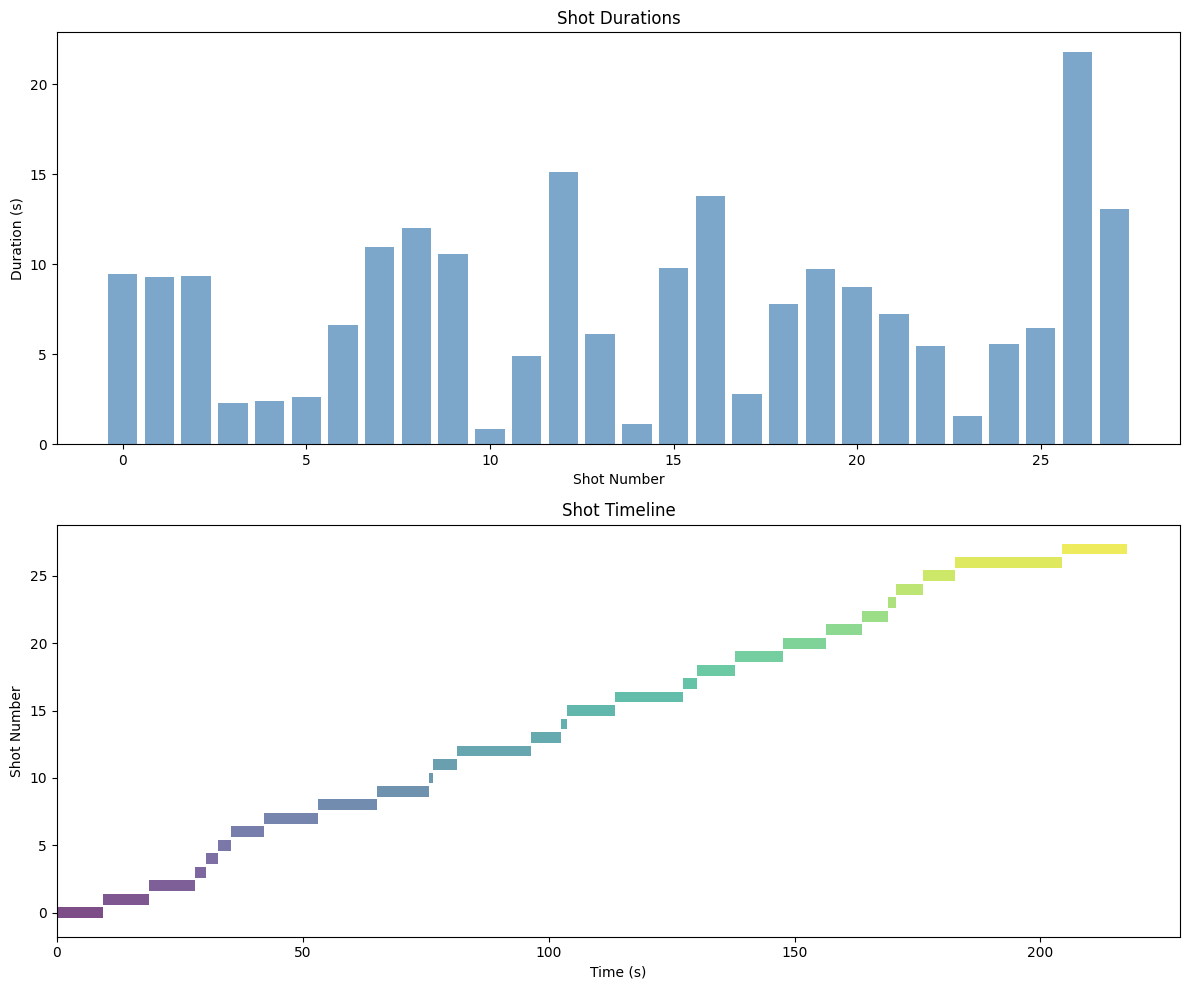


📊 SHOT STATISTICS
Total shots: 28
Average shot duration: 7.77 s
Shortest: 0.83 s
Longest: 21.79 s
Total video duration: 217.52 s
🖼️ Extracting representative frames...
Scene 01: Extracted 3 frames
Scene 02: Extracted 3 frames
Scene 03: Extracted 3 frames
Scene 04: Extracted 3 frames
Scene 05: Extracted 3 frames
Scene 06: Extracted 3 frames
Scene 07: Extracted 3 frames
Scene 08: Extracted 3 frames
Scene 09: Extracted 3 frames
Scene 10: Extracted 3 frames
Scene 11: Extracted 3 frames
Scene 12: Extracted 3 frames
Scene 13: Extracted 3 frames
Scene 14: Extracted 3 frames
Scene 15: Extracted 3 frames
Scene 16: Extracted 3 frames
Scene 17: Extracted 3 frames
Scene 18: Extracted 3 frames
Scene 19: Extracted 3 frames
Scene 20: Extracted 3 frames
Scene 21: Extracted 3 frames
Scene 22: Extracted 3 frames
Scene 23: Extracted 3 frames
Scene 24: Extracted 3 frames
Scene 25: Extracted 3 frames
Scene 26: Extracted 3 frames
Scene 27: Extracted 3 frames
Scene 28: Extracted 3 frames
✅ Frames saved to '

('Scene_04', 28.111416666666667, 30.413716666666666)

In [ ]:
# 1. Initialize detector
detector = BoxingShotDetector(threshold=30.0, min_scene_len=15)

# 2. Set video path (update the path to your local file)
path = input("Enter video path :")
detector.set_video_path(path)

# 3. Detect shots
detector.detect_shots()

# 4. Display shot info
df = detector.display_shots_info()
df.head()

# 5. Export to CSV
detector.export_shots_csv("shots_output.csv")

# 6. Visualize
detector.visualize_shots()

# 7. Extract frames
detector.extract_shot_frames()

# 8. Analyze patterns
detector.analyze_shot_patterns()

# 9. Find which scene contains a timestamp (e.g., 30 seconds)
detector.get_shot_by_time(30)


In [11]:
# ------------------------------
# Install required packages before running (in a terminal or notebook cell):
# !pip install scenedetect[opencv] opencv-python matplotlib pandas numpy
# ------------------------------

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scenedetect import VideoManager, SceneManager
from scenedetect.detectors import ContentDetector
from scenedetect import FrameTimecode
import numpy as np
from datetime import timedelta

class BoxingShotDetector:
    def __init__(self, threshold=30.0, min_scene_len=1.0):
        self.threshold = threshold
        self.min_scene_len = min_scene_len
        self.scenes = []
        self.video_path = None
        
    def set_video_path(self, path):
        """Set the path to the video file."""
        if os.path.exists(path):
            self.video_path = path
            print(f"✅ Video loaded: {path}")
        else:
            print("❌ File not found.")
    
    def detect_shots(self):
        """Detect shots using PySceneDetect."""
        if not self.video_path:
            print("❌ No video path specified!")
            return []
        
        try:
            video_manager = VideoManager([self.video_path])
            scene_manager = SceneManager()
            
            # Convert min_scene_len to FrameTimecode for compatibility
            video_manager.start()
            fps = video_manager.get_framerate()
            min_scene_timecode = FrameTimecode(self.min_scene_len, fps=fps)
            video_manager.release()
            
            # Restart video manager for scene detection
            video_manager = VideoManager([self.video_path])
            scene_manager.add_detector(ContentDetector(threshold=self.threshold, min_scene_len=min_scene_timecode))
            video_manager.start()
            scene_manager.detect_scenes(frame_source=video_manager)
            self.scenes = scene_manager.get_scene_list()
            video_manager.release()
            print(f"🎬 Detected {len(self.scenes)} shots/scenes.")
            return self.scenes
        except Exception as e:
            print(f"❌ Error during scene detection: {str(e)}")
            # Fallback: try without min_scene_len parameter
            try:
                print("🔄 Trying fallback method...")
                video_manager = VideoManager([self.video_path])
                scene_manager = SceneManager()
                scene_manager.add_detector(ContentDetector(threshold=self.threshold))
                video_manager.start()
                scene_manager.detect_scenes(frame_source=video_manager)
                self.scenes = scene_manager.get_scene_list()
                video_manager.release()
                print(f"🎬 Detected {len(self.scenes)} shots/scenes (fallback method).")
                return self.scenes
            except Exception as e2:
                print(f"❌ Fallback method also failed: {str(e2)}")
                return []

    def format_time(self, seconds):
        return str(timedelta(seconds=seconds))

    def display_shots_info(self):
        if not self.scenes:
            print("No scenes detected.")
            return
        
        print("\n" + "="*60)
        print("DETECTED CAMERA SHOTS/SCENES")
        print("="*60)
        shot_data = []

        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            duration = end - start
            shot_data.append({
                'Shot': f'Scene_{i+1:02d}',
                'Start_Time': self.format_time(start),
                'End_Time': self.format_time(end),
                'Duration': f"{duration:.2f}s",
                'Start_Seconds': start,
                'End_Seconds': end
            })
            print(f"Scene {i+1:02d}: {self.format_time(start)} - {self.format_time(end)} (Duration: {duration:.2f}s)")

        return pd.DataFrame(shot_data)
    
    def export_shots_csv(self, filename="boxing_shots.csv"):
        if not self.scenes:
            print("❌ No scenes to export!")
            return
        
        shot_data = []
        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            duration = end - start
            shot_data.append({
                'shot_id': f'scene_{i+1:02d}',
                'start_time_formatted': self.format_time(start),
                'end_time_formatted': self.format_time(end),
                'start_seconds': start,
                'end_seconds': end,
                'duration_seconds': duration,
                'shot_number': i+1
            })
        
        df = pd.DataFrame(shot_data)
        df.to_csv(filename, index=False)
        print(f"📁 Shot data exported to '{filename}'")
        return df

    def visualize_shots(self):
        if not self.scenes:
            print("No scenes to visualize.")
            return
        
        durations = [scene[1].get_seconds() - scene[0].get_seconds() for scene in self.scenes]
        start_times = [scene[0].get_seconds() for scene in self.scenes]
        end_times = [scene[1].get_seconds() for scene in self.scenes]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Bar chart
        ax1.bar(range(len(durations)), durations, color='steelblue', alpha=0.7)
        ax1.set_title("Shot Durations")
        ax1.set_xlabel("Shot Number")
        ax1.set_ylabel("Duration (s)")

        # Timeline
        for i, (start, end) in enumerate(zip(start_times, end_times)):
            ax2.barh(i, end - start, left=start, height=0.8,
                     color=plt.cm.viridis(i / len(self.scenes)), alpha=0.7)
        
        ax2.set_title("Shot Timeline")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Shot Number")

        plt.tight_layout()
        plt.show()

        print("\n📊 SHOT STATISTICS")
        print(f"Total shots: {len(durations)}")
        print(f"Average shot duration: {np.mean(durations):.2f} s")
        print(f"Shortest: {np.min(durations):.2f} s")
        print(f"Longest: {np.max(durations):.2f} s")
        print(f"Total video duration: {end_times[-1]:.2f} s")

    def extract_shot_frames(self, output_dir="shot_frames", max_frames_per_shot=3):
        if not self.scenes:
            print("No scenes to extract frames from.")
            return
        
        os.makedirs(output_dir, exist_ok=True)
        cap = cv2.VideoCapture(self.video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        print("🖼️ Extracting representative frames...")
        for i, scene in enumerate(self.scenes):
            start_frame = int(scene[0].get_seconds() * fps)
            end_frame = int(scene[1].get_seconds() * fps)
            total_frames = end_frame - start_frame

            if total_frames <= max_frames_per_shot:
                frame_positions = list(range(start_frame, end_frame))
            else:
                step = total_frames // max_frames_per_shot
                frame_positions = [start_frame + j * step for j in range(max_frames_per_shot)]

            for j, frame_pos in enumerate(frame_positions):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
                ret, frame = cap.read()
                if ret:
                    frame_filename = os.path.join(output_dir, f"scene_{i+1:02d}_frame_{j+1:02d}.jpg")
                    cv2.imwrite(frame_filename, frame)

            print(f"Scene {i+1:02d}: Extracted {len(frame_positions)} frames")
        cap.release()
        print(f"✅ Frames saved to '{output_dir}'")

    def analyze_shot_patterns(self):
        durations = [scene[1].get_seconds() - scene[0].get_seconds() for scene in self.scenes]
        rapid_cuts = [i for i, d in enumerate(durations) if d < 2.0]
        long_shots = [i for i, d in enumerate(durations) if d > 10.0]
        print("\n📌 Shot Pattern Analysis:")
        print(f"Rapid cuts (<2s): {len(rapid_cuts)} → {rapid_cuts}")
        print(f"Long shots (>10s): {len(long_shots)} → {long_shots}")
        return rapid_cuts, long_shots

    def get_shot_by_time(self, timestamp_seconds):
        for i, scene in enumerate(self.scenes):
            start = scene[0].get_seconds()
            end = scene[1].get_seconds()
            if start <= timestamp_seconds <= end:
                return f"Scene_{i+1:02d}", start, end
        return None, None, None

def create_annotated_video(input_video_path, output_video_path="annotated_video.mp4", 
                          threshold=30.0, min_scene_len=1.0, 
                          show_scene_changes=True, show_scene_info=True,
                          show_timestamp=True, annotation_color=(0, 255, 0)):
    """
    Create an annotated video with scene detection markings.
    
    Parameters:
    - input_video_path: Path to input video file
    - output_video_path: Path for output annotated video
    - threshold: Scene detection sensitivity (lower = more sensitive)
    - min_scene_len: Minimum scene length in seconds (will be converted to frames)
    - show_scene_changes: Whether to show visual indicators at scene changes
    - show_scene_info: Whether to display current scene information
    - show_timestamp: Whether to show current timestamp
    - annotation_color: RGB color tuple for annotations (default: green)
    
    Returns:
    - detector: BoxingShotDetector object with detected scenes
    - success: Boolean indicating if annotation was successful
    """
    
    print(f"🎬 Starting video annotation for: {input_video_path}")
    
    # Check if input file exists
    if not os.path.exists(input_video_path):
        print(f"❌ Input video file not found: {input_video_path}")
        return None, False
    
    # Initialize detector and detect scenes
    detector = BoxingShotDetector(threshold=threshold, min_scene_len=min_scene_len)
    detector.set_video_path(input_video_path)
    
    if not detector.video_path:
        return detector, False
    
    scenes = detector.detect_shots()
    if not scenes:
        print("❌ No scenes detected!")
        return detector, False
    
    # Open video for reading
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("❌ Could not open video file!")
        return detector, False
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video info: {width}x{height} @ {fps}fps, {total_frames} frames")
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    if not out.isOpened():
        print("❌ Could not create output video file!")
        cap.release()
        return detector, False
    
    # Prepare scene change indicators
    scene_change_frames = set()
    if show_scene_changes:
        for scene in scenes[1:]:  # Skip first scene
            frame_num = int(scene[0].get_seconds() * fps)
            # Mark a few frames around the scene change
            for offset in range(-2, 3):
                scene_change_frames.add(frame_num + offset)
    
    print("🎨 Annotating video frames...")
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        current_time = frame_count / fps
        
        # Find current scene
        current_scene_id, scene_start, scene_end = detector.get_shot_by_time(current_time)
        current_scene_num = None
        if current_scene_id:
            current_scene_num = int(current_scene_id.split('_')[1])
        
        # Add scene change indicator
        if show_scene_changes and frame_count in scene_change_frames:
            # Add a bright border to indicate scene change
            cv2.rectangle(frame, (0, 0), (width-1, height-1), (0, 0, 255), 10)
            # Add text
            cv2.putText(frame, "SCENE CHANGE", (50, 80), 
                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
        
        # Prepare annotation text
        annotations = []
        
        if show_timestamp:
            time_str = detector.format_time(current_time)
            annotations.append(f"Time: {time_str}")
        
        if show_scene_info and current_scene_id:
            scene_duration = scene_end - scene_start
            scene_progress = ((current_time - scene_start) / scene_duration) * 100
            annotations.append(f"Scene: {current_scene_num}")
            annotations.append(f"Duration: {scene_duration:.1f}s")
            annotations.append(f"Progress: {scene_progress:.1f}%")
        
        # Draw annotations
        y_offset = 30
        for annotation in annotations:
            # Add background rectangle for better readability
            (text_width, text_height), _ = cv2.getTextSize(annotation, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(frame, (10, y_offset - text_height - 5), 
                         (10 + text_width + 10, y_offset + 5), (0, 0, 0), -1)
            
            # Add text
            cv2.putText(frame, annotation, (15, y_offset), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, annotation_color, 2)
            y_offset += 35
        
        # Draw scene progress bar
        if show_scene_info and current_scene_id:
            bar_width = 300
            bar_height = 10
            bar_x = width - bar_width - 20
            bar_y = 20
            
            # Background bar
            cv2.rectangle(frame, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), 
                         (100, 100, 100), -1)
            
            # Progress bar
            progress_width = int((scene_progress / 100) * bar_width)
            cv2.rectangle(frame, (bar_x, bar_y), (bar_x + progress_width, bar_y + bar_height), 
                         annotation_color, -1)
            
            # Bar outline
            cv2.rectangle(frame, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), 
                         (255, 255, 255), 2)
        
        # Write frame to output video
        out.write(frame)
        frame_count += 1
        
        # Progress indicator
        if frame_count % (fps * 10) == 0:  # Every 10 seconds
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {progress:.1f}% ({frame_count}/{total_frames} frames)")
    
    # Cleanup
    cap.release()
    out.release()
    
    print(f"✅ Annotated video saved to: {output_video_path}")
    print(f"📊 Processing complete: {frame_count} frames processed")
    
    return detector, True

# Example usage function
def annotate_boxing_video(video_path, output_path=None):
    """
    Simple wrapper function for annotating boxing videos with default settings.
    
    Parameters:
    - video_path: Path to the input video
    - output_path: Path for output video (optional, auto-generated if None)
    
    Returns:
    - detector: BoxingShotDetector object with analysis results
    """
    if output_path is None:
        base_name = os.path.splitext(os.path.basename(video_path))[0]
        output_path = f"{base_name}_annotated.mp4"
    
    detector, success = create_annotated_video(
        input_video_path=video_path,
        output_video_path=output_path,
        threshold=30.0,  # Good for boxing videos
        min_scene_len=1.0,  # Minimum 1 second scenes
        show_scene_changes=True,
        show_scene_info=True,
        show_timestamp=True,
        annotation_color=(0, 255, 0)  # Green annotations
    )
    
    if success:
        # Display analysis
        detector.display_shots_info()
        detector.analyze_shot_patterns()
        
        # Export CSV data
        csv_name = f"{os.path.splitext(output_path)[0]}_scenes.csv"
        detector.export_shots_csv(csv_name)
        
        print(f"\n🎯 Video annotation complete!")
        print(f"📹 Annotated video: {output_path}")
        print(f"📊 Scene data: {csv_name}")
    
    return detector

# Example usage:
detector = annotate_boxing_video("box2.mp4")
# 
# Or with custom settings:
# detector, success = create_annotated_video(
#     "my_boxing_match.mp4",
#     "custom_annotated.mp4",
#     threshold=25.0,
#     show_scene_changes=True
# )

VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.
VideoManager is deprecated and will be removed.


🎬 Starting video annotation for: box2.mp4
✅ Video loaded: box2.mp4
❌ Error during scene detection: bad operand type for unary -: 'FrameTimecode'
🔄 Trying fallback method...
🎬 Detected 21 shots/scenes (fallback method).
📹 Video info: 1280x720 @ 25fps, 2445 frames
🎨 Annotating video frames...
Progress: 10.2% (250/2445 frames)
Progress: 20.4% (500/2445 frames)
Progress: 30.7% (750/2445 frames)
Progress: 40.9% (1000/2445 frames)
Progress: 51.1% (1250/2445 frames)
Progress: 61.3% (1500/2445 frames)
Progress: 71.6% (1750/2445 frames)
Progress: 81.8% (2000/2445 frames)
Progress: 92.0% (2250/2445 frames)
✅ Annotated video saved to: box2_annotated.mp4
📊 Processing complete: 2445 frames processed

DETECTED CAMERA SHOTS/SCENES
Scene 01: 0:00:00 - 0:00:09.840000 (Duration: 9.84s)
Scene 02: 0:00:09.840000 - 0:00:13.200000 (Duration: 3.36s)
Scene 03: 0:00:13.200000 - 0:00:17.480000 (Duration: 4.28s)
Scene 04: 0:00:17.480000 - 0:00:18.800000 (Duration: 1.32s)
Scene 05: 0:00:18.800000 - 0:00:23.680000